
# Dataset y consigna del TP


Descargar el dataset **Global Climate Change Data** https://data.world/data-society/global-climate-change-data

<ul>
<li>Graficar una serie a partir de un dataset relevante. Describir observaciones.</li>
<li> Descomponer una serie de tiempo usando el modelo aditivo de cuatro componentes. </li>
<li> Extraer la tendencia y ajustar un modelo determinístico. Explicar su relación con el
contexto. Obtener conclusiones acerca de la validez del modelo. </li>
<li> <b> Entrega clase 4: </b> Evaluar si la serie original es estacionaria. Aplicar transformaciones
(preprocesamiento), graficar autocorrelación, autocorrelación parcial y extraer
conclusiones.
<li> <b>Entrega clase 6:</b> A partir de las transformaciones propuestas ajustar distintos modelos
(S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad
del modelo.
<li> Ajustar y predecir usando redes neuronales LSTM. Comparar con predicciones
usando SARIMA y extraer conclusiones. </li>
<li> Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y
comparar con las componentes cíclica y estacional usando la descomposición. </li>
<li> <b> Entrega clase 8: </b> Presentación incluyendo introducción, gráficos, modelos propuestos,
expresiones analíticas y conclusiones. </li>

</ul>

# Importar librerías


In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Cargar datos
Cargar el dataset

In [2]:
from cmath import isnan


PATH_DATASET = "dataset-GlobalTemperatures.csv"

df = pd.read_csv(PATH_DATASET, delimiter=',')
df = df[['dt', 'LandAverageTemperature']]   # Extraigo solo columnas de interes
df = df.rename(columns={'LandAverageTemperature': 'temp'})

# Look at the dataset
# df.info()
print('\n Null count: \n', df.isnull().sum() )

# Hay 12 valores null en la temperatura. Imputo el promedio entre día anterior y posterior
nulls_index = df[df['temp'].isnull()].index.tolist()

for i in nulls_index:
    new_val = (df.at[i-1,'temp'] + df.at[i+1,'temp'])*0.5
    if(isnan(new_val) == True):   # Go backwards and find a valid value
        offset = 1
        prev_val = df.at[i-offset,'temp']
        while(isnan(prev_val)):
            offset += 1
            prev_val = df.at[i-offset,'temp']
        new_val = prev_val

    df.loc[i, 'temp'] = new_val
print('\n Null count after imputation: \n', df.isnull().sum() )
    
# Proceso columna de fecha para convertirla en datetime
df['dt'] = pd.to_datetime(df['dt'])
print(df.dtypes)

# Por último, seteo la fecha como indice del dataframe. Esto permite acceso cómodo
df = df.set_index('dt')

data = df.to_numpy().flatten()



 Null count: 
 dt       0
temp    12
dtype: int64

 Null count after imputation: 
 dt      0
temp    0
dtype: int64
dt      datetime64[ns]
temp           float64
dtype: object


In [3]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    3192 non-null   float64
dtypes: float64(1)
memory usage: 49.9 KB
None
              temp
dt                
1750-01-01   3.034
1750-02-01   3.083
1750-03-01   5.626
1750-04-01   8.490
1750-05-01  11.573


# Gráficos

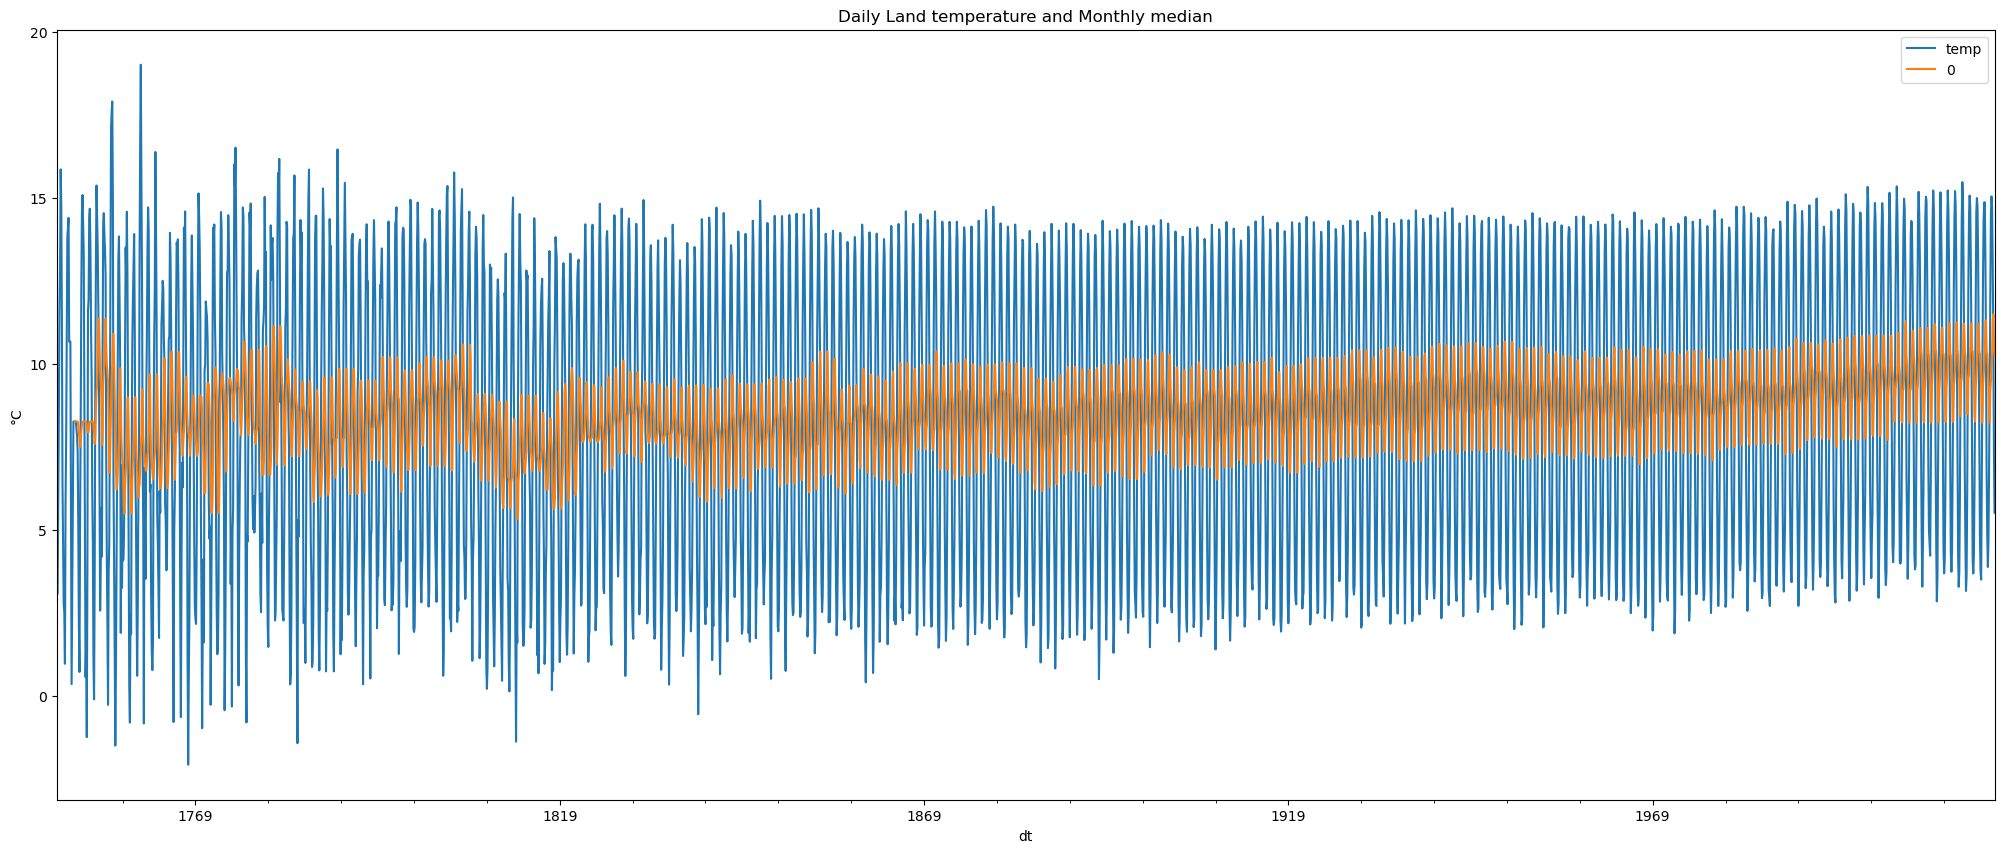

In [4]:
import pandas.core.window.rolling

myAx = df.plot(figsize=(25,10), title='Daily Land temperature and Monthly median', xlabel='year', ylabel='°C')

s = pd.Series(data).rolling(30).median()
median = pd.DataFrame(s).set_index(df.index)
median.plot(ax=myAx)
plt.show()

Se puede ver que la serie presenta muchas variaciones a lo largo de los 265 años que se registraron. Dado que son registros diarios, el gráfico se vuelve muy ruidoso. Por ello se graficó encima la mediana móvil de 30 días de muestras. Esta mediana muestra que la serie tiene una tendencia a aumentar, por lo que se puede pensar que se trata de una serie no estacionaria.<br>

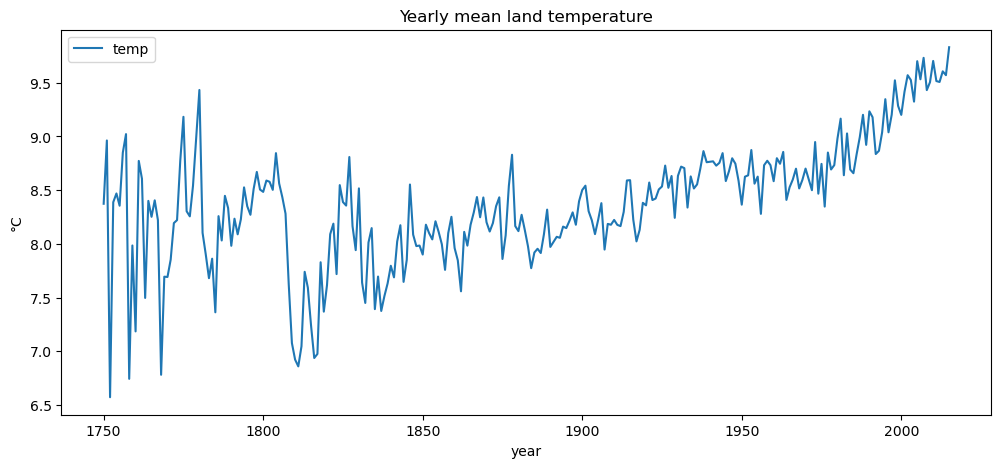

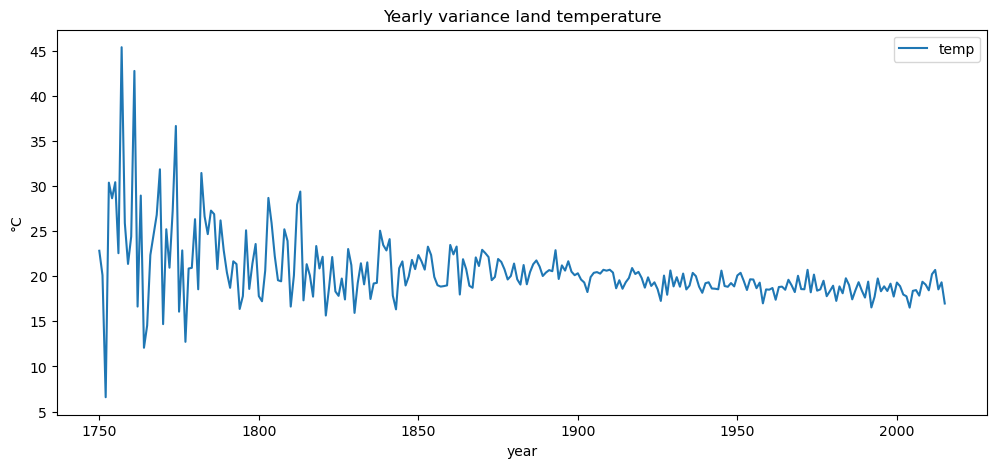

In [5]:
df.groupby(df.index.year).mean().plot(figsize=(12,5), title='Yearly mean land temperature', xlabel='year', ylabel='°C')
df.groupby(df.index.year).var().plot(figsize=(12,5), title='Yearly variance land temperature', xlabel='year', ylabel='°C')
plt.show()

El efecto de la tendencia se puede ver aún mejor si agrupamos los datos por año y calculamos el promedio anual de la temperatura. Con este gráfico se puede ver claramente que la temperatura global promedio anual tiene una tendencia a subir. Incluso se nota una gran aceleración en la escalada con un punto de inflexión significativo alrededor de los años 1960 y 1980.
Otro factor interesante se puede ver en la varianza de la temperatura anual. Se puede ver una disminución progresiva en la varianza, indicando que en cada año hay menor dispersión de los datos, manteniendo mayor uniformidad a lo largo de las distintas estaciones.
Cómo se propuso anteriormente, se puede ver claramente que la serie no es estacionaria, dado que la media y la varianza no se mantienen constantes a lo largo del tiempo.

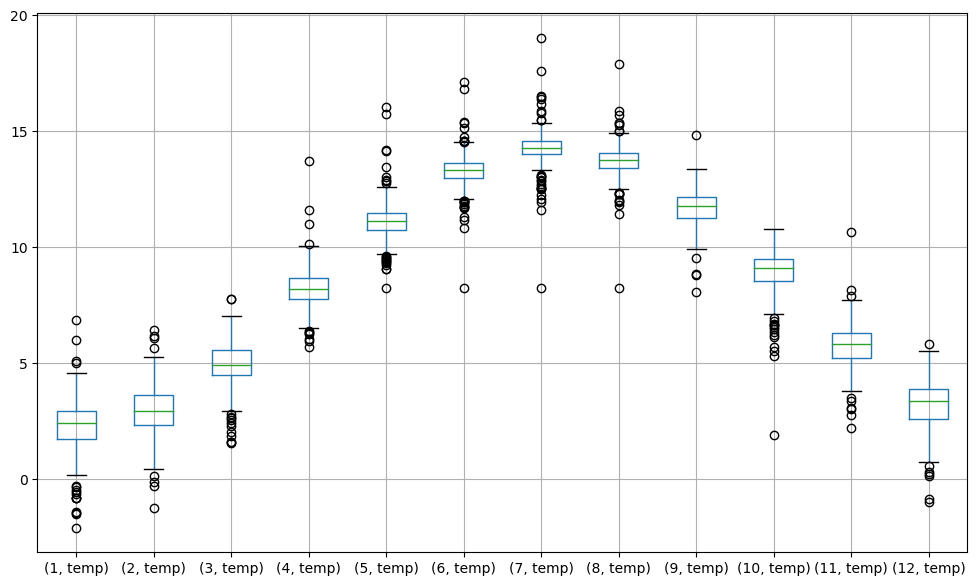

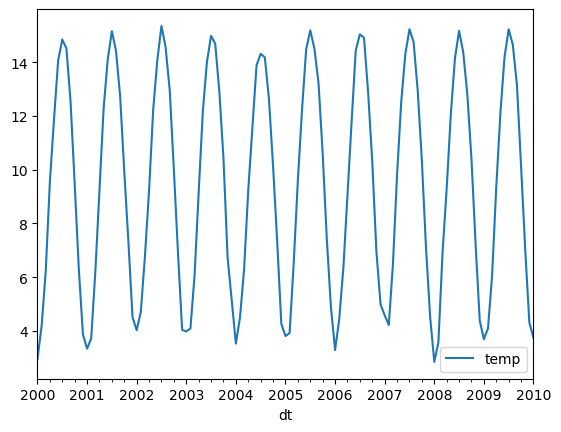

In [6]:
# Ahora veamos la estacionalidad
df.groupby(df.index.month).boxplot(subplots=False, sharex=True, figsize=(12,7))
df['1/1/2000':'1/1/2010'].plot()
plt.show()

Acá se puede ver la estacionalidad de la serie, algo que no se podía apreciar en el gráfico anterior debido a la cantidad de muestras. En el primer gráfico se puede ver la distribución de cada mes a lo largo de todos los años. Acá se puede ver la estacionalidad de la serie a lo largo de un año. Estas variaciones se deben a la cercanía de la tierra con el sol a lo largo de un año.
En el segundo gráfico se presenta la serie original, con las T° de cada día, pero en un período de 10 años. Esto permite apreciar las estaciones y se puede ver que el período de ciclos es de 1 año. La tendencia dentro de cada ciclo se denomina tendencia determinística, ya que se repite de forma predecible. Por esta razón, es importante descartar esta componente cíclica para hacer un análisis de la tendencia subyacente de la serie.

# Descomposición del modelo

<Figure size 1000x700 with 0 Axes>

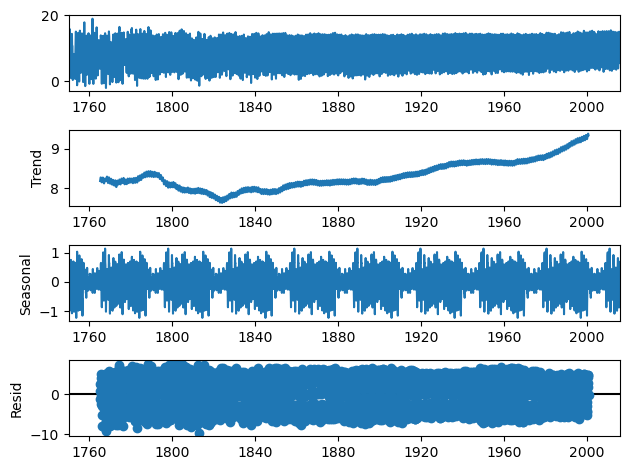

In [7]:
# Descomponemos el modelo usando un modelo aditivo con el período que determinamos antes
period=365
df_dec = sm.tsa.seasonal_decompose(df, model='additive', period=period)
fig=plt.figure(figsize=(10,7))
dec_plt = df_dec.plot()
plt.show()

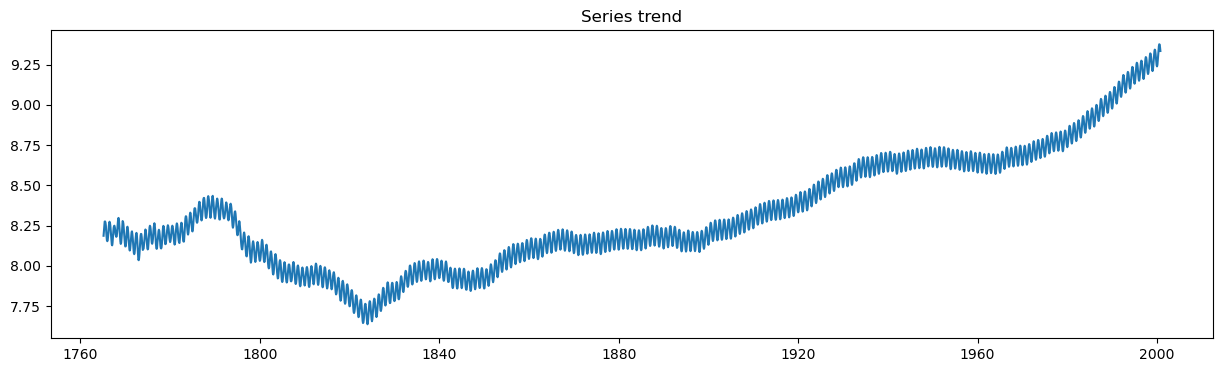

In [8]:
# Extraemos la curva de tendencia exclusivamente
fig=plt.figure(figsize=(15,4))
trend = df_dec._trend.dropna()  # Drop nans
plt.plot(trend)
plt.title('Series trend')
plt.show()

# Analisis Estacionaridad

Para ver estacionaridad, proponemos 2 metodos:
<ul>
<li> Por autocorrelación </li>
<li> Por test de Dickey-Fuller </li>
</ul>

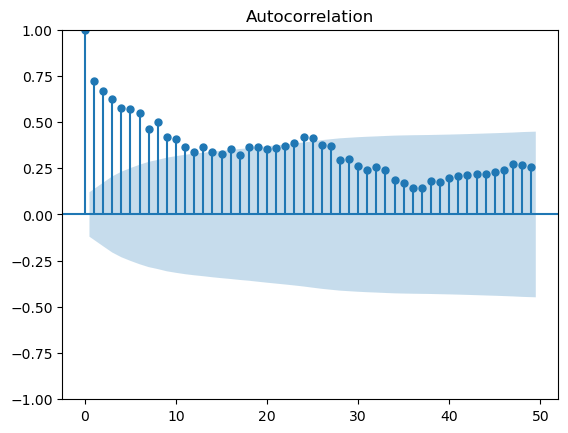

In [9]:
### CONSULTAR!!!
dpor = plot_acf(df.groupby(df.index.year).mean(), lags=np.arange(50))
plt.show()

Por autocorrelación, podemos ver que la autocorrelación se hace cercana a cero para lags cercanos a 20. Esto es un indicio de que la serie no es estacionaria.

In [10]:
from statsmodels.tsa.stattools import adfuller
def my_adfuller(serie):
    print(f'Augmented Dickey-Fuller Test')
    result = adfuller(serie.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Mucha evidencia para rechazar Ho")
        print("Ho: Existe no estacionareidad")
        print("La serie es estacionaria")
    else:
        print("Poca evidencia para rechazar Ho")
        print("Ho: Existe no estacionareidad")
        print("No se puede rechazar hipotesis nula")

my_adfuller(trend)

Augmented Dickey-Fuller Test
ADF test statistic         1.320352
p-value                    0.996720
# lags used               24.000000
# observations          2803.000000
critical value (1%)       -3.432685
critical value (5%)       -2.862572
critical value (10%)      -2.567319
Poca evidencia para rechazar Ho
Ho: Existe no estacionareidad
No se puede rechazar hipotesis nula


Dado que el valor del test (1.3) dió mayor a los valores críticos (1%, 5%, 10%), no podemos descartar la hipotesis nula de DFuller (Ho: Existe no estacionaridad en la serie).
Además, el p-valor es cercano a 1, por lo que con seguridad no podemos descartar la hipotesis nula.
Por lo tanto, la tendencia de la serie es no estacionaria.

# Ajuste de modelo

## Separacion train-test
En primer lugar, se puede notar en la serie que hay una variación notoria en el comportamiento a partir del año 1825 aproximadamente. Luego de este momento, la serie comienza a crecer de
forma constante. Este comportamiento también se nota en la varianza de la serie (graficada anteriormente). Habiendo notado esta diferencia, quitaremos la primer parte de la serie ya que 
se considera que no tenemos suficientes datos para conocer si este comportamiento es algo repetitivo o no. Sin embargo, a partir de 1825, notamos un aumento progresivo, que es lo que intentaremos modelar.
En primer lugar, separamos en train y test para luego poder calcular alguna metrica de las predicciones que hagamos y tener confianza en el modelo

In [32]:
index_t0 = 75 * 12  # Start from the year 1825
data = df['temp'].values[index_t0:]
train_prc = 0.9 # Percentage of dataset to use for train
index=int(len(data)*train_prc)
y_train=data[:index]
y_test=data[index:]
print(f'Train: {len(y_train)} - Test: {len(y_test)}')

Train: 2062 - Test: 230


## Tendencia
En una primera instancia, intentamos ajustar un modelo polinómico por cuadrados mínimos a la tendencia, con el objetivo de intentar predecir la serie.


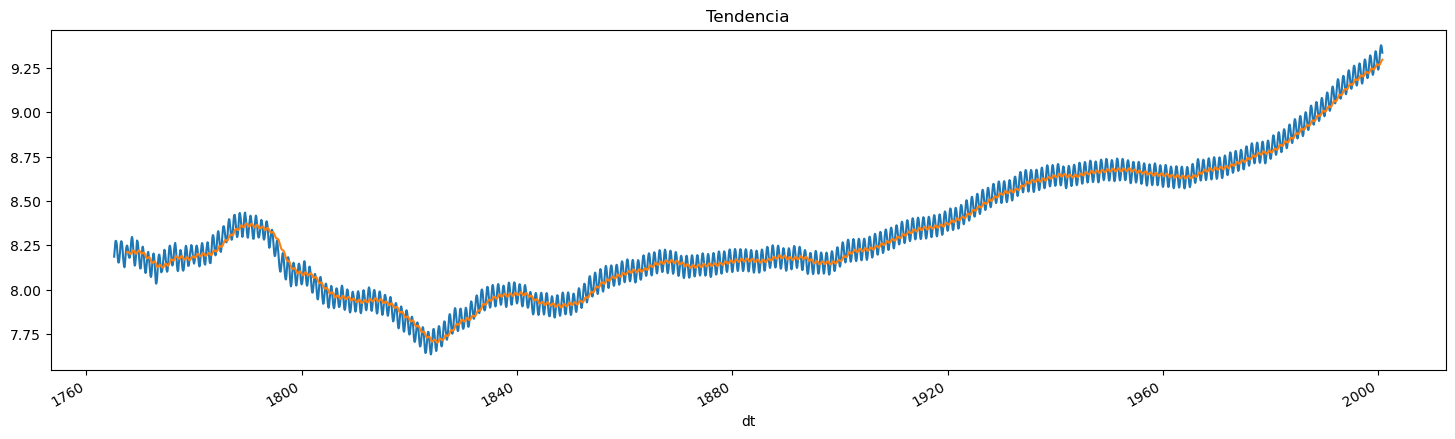

In [13]:
# En primer lugar, filtramos la tendencia usando moving average para obtener un mejor ajuste 
trend_filt = pd.Series(trend).rolling(30).mean()
plt.figure(figsize=(18,5))
myAx = plt.plot(trend)
trend_filt.plot()
plt.title("Tendencia")
plt.show()

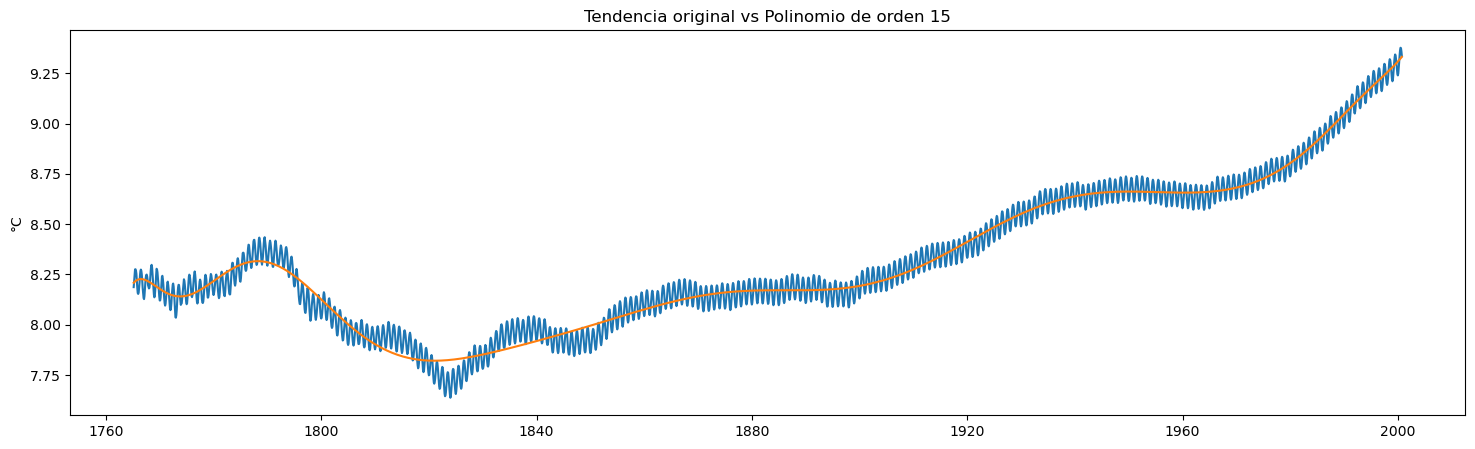

In [14]:
poly_degree = 15    # Orden del polinomio a ajustar

x = np.arange(len(trend.index))
z = np.polyfit(x, trend.values, deg=poly_degree)  # Fitteo el polinomio:

# Ahora creo polinomio y computo nuevos valores para graficar
p = np.poly1d(z)    
trend_poly = trend.copy()
for i in x:
    trend_poly[i] = p(i)

# Grafico para comparar
plt.figure(figsize=(18,5))
plt.plot(trend)
plt.plot(trend_poly)
a= plt.title(('Tendencia original vs Polinomio de orden ' + str(poly_degree)))
a= plt.ylabel('°C')
plt.show()

Se puede ver que con un polinomio de grado 15, la tendencia se ajusta relativamente bien. Esto nos permitiría predecir, de una forma muy sencilla, cómo se esperaría que avance la serie temporal.

## SARIMA

Ahora intentaremos analizar la serie con un modelo más complejo. Para esto intentaremos usar SARIMA, dado que tenemos una componente estacional.

### Diferenciacion

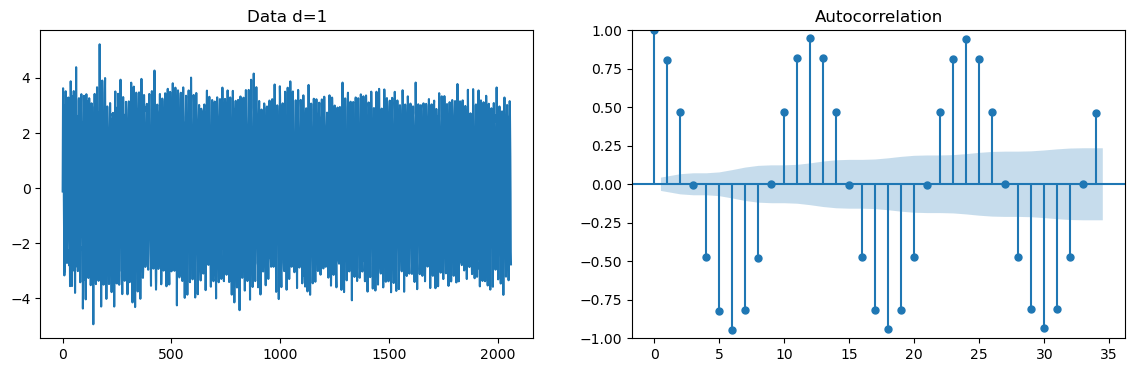

Augmented Dickey-Fuller Test
ADF test statistic     -1.306228e+01
p-value                 2.035713e-24
# lags used             2.600000e+01
# observations          2.034000e+03
critical value (1%)    -3.433569e+00
critical value (5%)    -2.862962e+00
critical value (10%)   -2.567527e+00
Mucha evidencia para rechazar Ho
Ho: Existe no estacionareidad
La serie es estacionaria


In [15]:
# Ya sabemos que la serie original no es estacionaria, por lo que diferenciamos una vez para eliminar la tendencia de la serie y luego analizamos estacionaridad
temp_d1 = pd.DataFrame((y_train - pd.Series(y_train).shift(1).values)[1:], columns=['temp'])
plt.figure(figsize=(14,4))
ax = plt.subplot(1,2,1)
plt.plot(temp_d1)
plt.title('Data d=1')
ax = plt.subplot(1,2,2)
a=plot_acf(temp_d1, ax=ax)
plt.show()
my_adfuller(temp_d1)

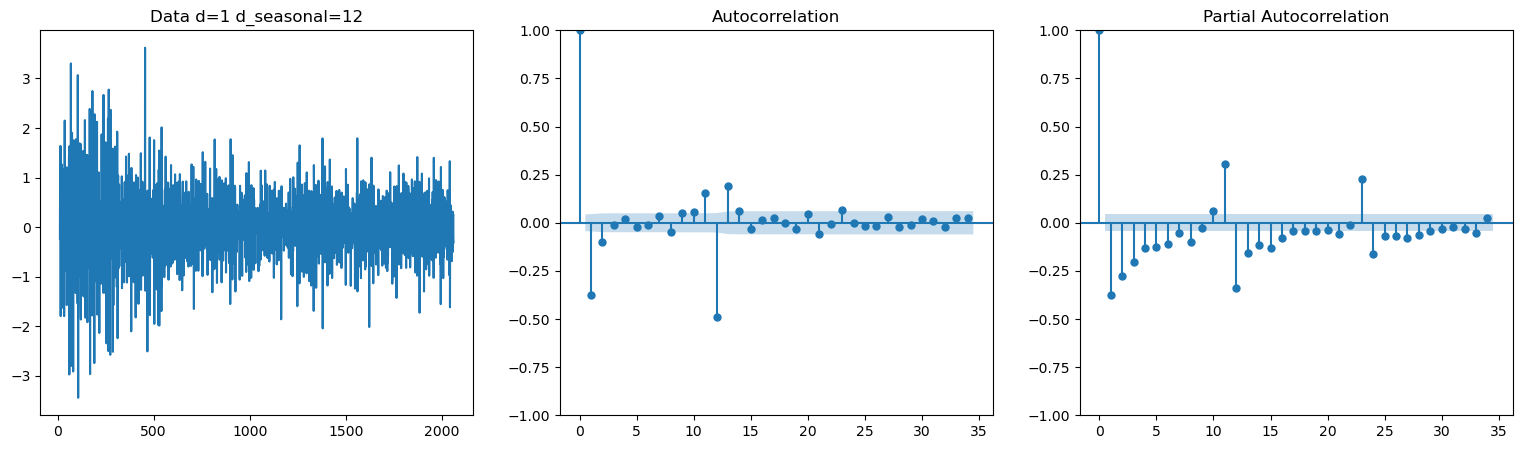

Augmented Dickey-Fuller Test
ADF test statistic     -1.516251e+01
p-value                 6.560360e-28
# lags used             2.600000e+01
# observations          2.022000e+03
critical value (1%)    -3.433588e+00
critical value (5%)    -2.862970e+00
critical value (10%)   -2.567532e+00
Mucha evidencia para rechazar Ho
Ho: Existe no estacionareidad
La serie es estacionaria


In [16]:
# Luego de diferenciar una vez, la serie se ve estacionari, pero aún se puede ver que la autocorrelación muestra una componente estacional.
# La autocorrelación sigue sin mostrar algo apropiado para hacer un modelado, por lo que diferencio una vez mas para sacar la componente estacional
temp_d1_s = pd.DataFrame((temp_d1['temp'] - temp_d1['temp'].shift(12))[12:], columns=['temp'])
plt.figure(figsize=(19,5))
ax = plt.subplot(1,3,1)
plt.plot(temp_d1_s)
plt.title('Data d=1 d_seasonal=12')
ax = plt.subplot(1,3,2)
a=plot_acf(temp_d1_s, ax=ax)
ax = plt.subplot(1,3,3)
a=plot_pacf(temp_d1_s, method='ywm', ax=ax)
plt.show()
my_adfuller(temp_d1_s)

### Generación de modelos y comparación

In [17]:
# Basado en los resultados de los gráficos, proponemos distintos modelos SARIMA que podrían representar apropiadamente la serie.
# Para los modelos de SARIMA(p,d,q)(P,D,Q)m proponemos:
import itertools

p = [2,3,4]
q = [0,1,2]
d = [1]
P = [0,1]
Q = [0,1]
D = [1]

params = list(itertools.product(p,d,q,P,D,Q,[12]))

models = []
aic = []
bic = []
for i in params:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train, order=i[:3], seasonal_order=i[3:], enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=-1)
        this_aic = model_fit.aic
        this_bic = model_fit.bic
        print(f'SARIMA{i[:3]}x{i[3:]}12 - AIC={this_aic} - BIC={this_bic}')
        models.append(model)
        aic.append(this_aic)
        bic.append(this_bic)
    except:
        continue

SARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC=3681.2933151995835 - BIC=3698.165706956567
SARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC=2409.014817205445 - BIC=2431.4897867161267
SARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC=3047.4362538363603 - BIC=3069.909258227867
SARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC=2419.654767341985 - BIC=2447.7460228313685
SARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC=3328.6657833094005 - BIC=3351.1623056520457
SARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC=2080.55110083653 - BIC=2108.6423563259136
SARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC=2735.6586517625556 - BIC=2763.749907251939
SARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC=2082.555182692923 - BIC=2116.264689280183
SARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC=3260.7706861764805 - BIC=3288.888895909038
SARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC=2085.0252624038885 - BIC=2118.7318198635394
SARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC=2711.5653779320187 - BIC=2745.2748845192787
SARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC=2087.028192484955 - BIC=2126.3525095212144
SARIMA(3, 1, 0)x(0, 1, 0, 1

/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(0, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(0, 1, 1, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(1, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(1, 1, 1, 12)12 - AIC=nan - BIC=nan
SARIMA(3, 1, 2)x(0, 1, 0, 12)12 - AIC=3238.6688696613337 - BIC=3272.410721340403
SARIMA(3, 1, 2)x(0, 1, 1, 12)12 - AIC=2085.911208674192 - BIC=2125.2355257104514
SARIMA(3, 1, 2)x(1, 1, 0, 12)12 - AIC=2684.186155334023 - BIC=2723.5104723702825
SARIMA(3, 1, 2)x(1, 1, 1, 12)12 - AIC=2087.955871000528 - BIC=2132.897947613396
SARIMA(4, 1, 0)x(0, 1, 0, 12)12 - AIC=3549.3766655074937 - BIC=3577.492430849878
SARIMA(4, 1, 0)x(0, 1, 1, 12)12 - AIC=2267.1418556726994 - BIC=2300.854309938722
SARIMA(4, 1, 0)x(1, 1, 0, 12)12 - AIC=2916.2638111114056 - BIC=2949.967417993176
SARIMA(4, 1, 0)x(1, 1, 1, 12)12 - AIC=2258.1643417993478 - BIC=2297.485216494746


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(0, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(0, 1, 1, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(1, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(1, 1, 1, 12)12 - AIC=nan - BIC=nan
SARIMA(4, 1, 2)x(0, 1, 0, 12)12 - AIC=3231.403911359792 - BIC=3270.76598283913
SARIMA(4, 1, 2)x(0, 1, 1, 12)12 - AIC=2087.808783209676 - BIC=2132.750859822544
SARIMA(4, 1, 2)x(1, 1, 0, 12)12 - AIC=2670.4298772350076 - BIC=2715.3680197440344


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 2)x(1, 1, 1, 12)12 - AIC=2087.2382383935087 - BIC=2137.7936487161637


In [33]:
bm_index = np.nanargmin(aic)
best_model = models[bm_index].fit(disp=-1)
print(f'Best model is #{bm_index} --> SARIMA{params[bm_index][:3]}x{params[bm_index][3:]}12')
print(best_model.summary())

Best model is #5 --> SARIMA(2, 1, 1)x(0, 1, 1, 12)12
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2062
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1035.276
Date:                            Thu, 13 Oct 2022   AIC                           2080.551
Time:                                    20:49:29   BIC                           2108.642
Sample:                                         0   HQIC                          2090.857
                                           - 2062                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3117      0.016     19.313      0.000       

### Análisis de bondad

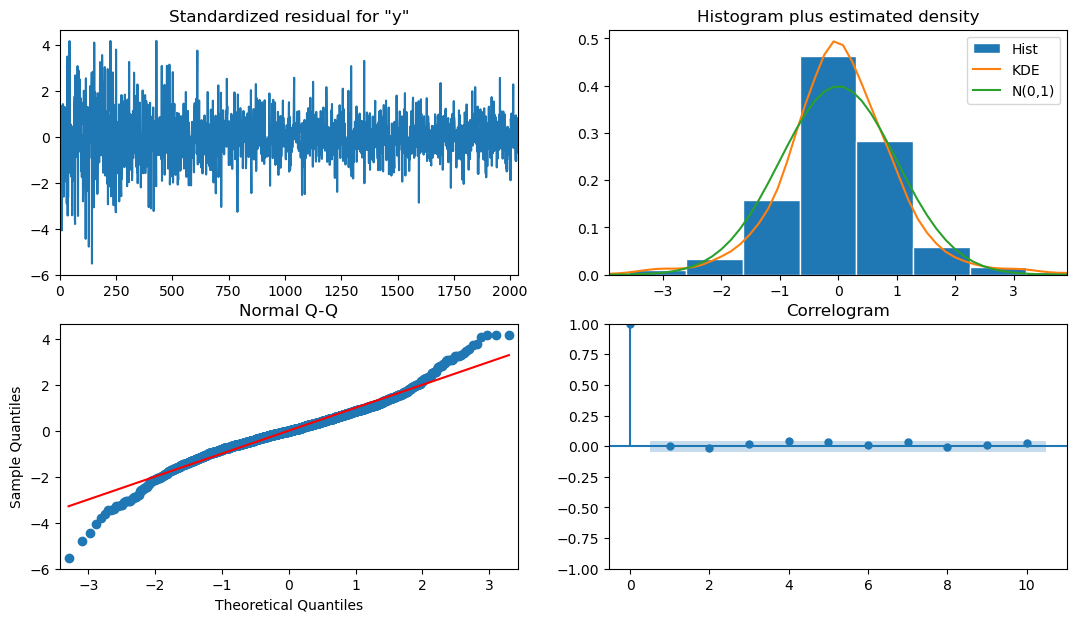

In [29]:
a=best_model.plot_diagnostics(figsize=(13,7))

# A partir del análisis de residuos resultante, se puede decir que el modelo se ajusta correctamente y es un modelo válido para la serie de tiempo de interés.
# Tanto el histograma como el QQplot muestran que los residuos tienen una distribución que se asemeja a la distribución normal, lo cuál es deseado.

# Predicción
Basandonos en el modelo SARIMA obtenido anteriormente, procedemos a intentar predecir la serie de tiempo, comparándola con el set de test.

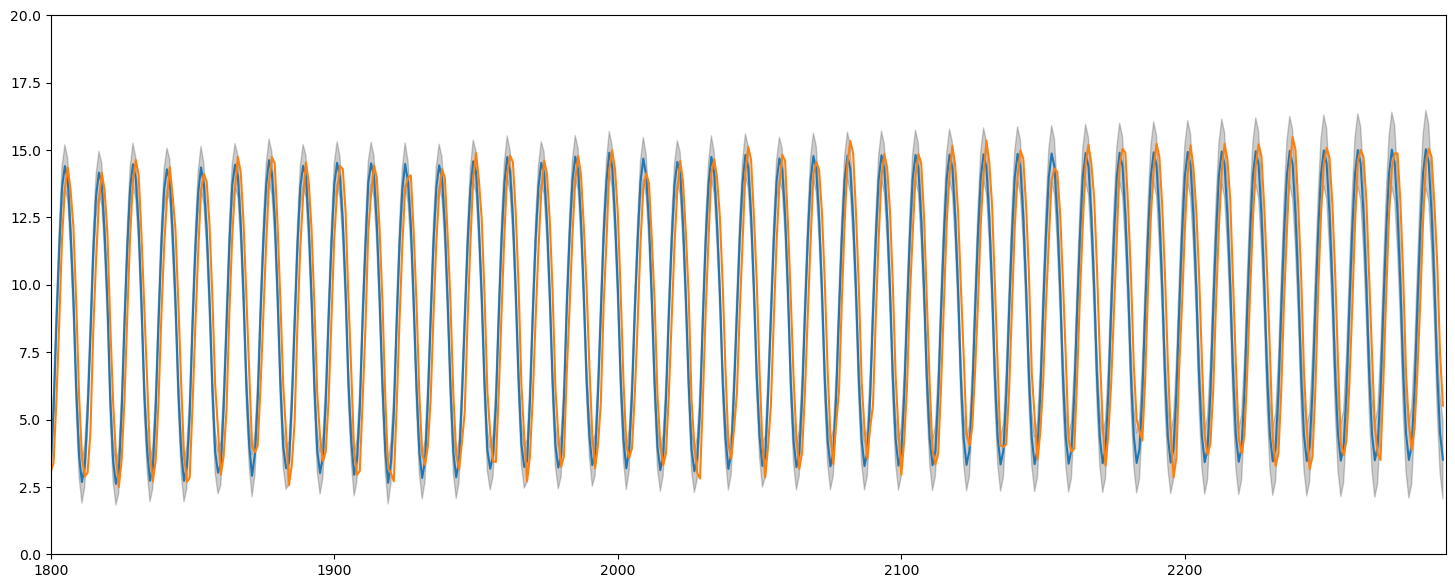

In [63]:
forecast = best_model.get_prediction(start=1, end=len(data))
pred = forecast.predicted_mean
ci = forecast.conf_int()

plt.figure(figsize=(18,7))
plt.xlim(1800, len(pred))
plt.ylim(0,20)
plt.plot(pred, label='Prediccion')
plt.plot(data, label='Real')
plt.fill_between(x=range(len(pred)), y1=ci[:, 0], y2=ci[:, 1], color='k', alpha=.2)
plt.show()

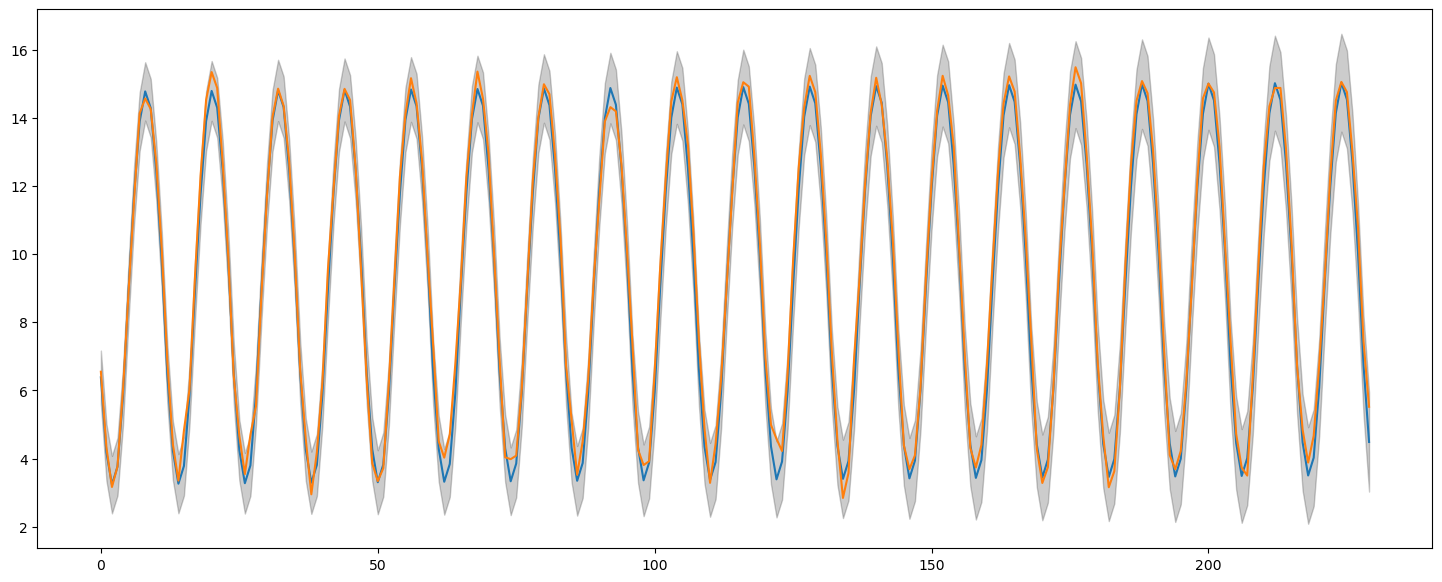

In [64]:
forecast = best_model.get_forecast(steps=len(y_test))
pred=forecast.predicted_mean
ci = forecast.conf_int()

plt.figure(figsize=(18,7))
plt.plot(pred, label='Prediccion')
plt.plot(y_test, label='Real')
plt.fill_between(x=range(len(pred)), y1=ci[:, 0], y2=ci[:, 1], color='k', alpha=.2)
plt.show()

In [44]:
print(ci)

[[-2.81277751e+03  2.81987110e+03]
 [-2.80508480e+03  2.81139949e+03]
 [-2.80190266e+03  2.81339769e+03]
 ...
 [ 5.28384308e+00  8.18729042e+00]
 [ 3.02979447e+00  5.94143683e+00]
 [ 2.05719172e+00  4.97595285e+00]]


- Como agregar la tendencia deterministica y evitar la lineal del sarima?
    Leer la documentacion. No hace falta hacerlo igual.`
- Seleccion de parametros SARIMA
    Preprocesar un poco mas la serie. Hacer algo para sacarme la variacion en la varianza sino, no es estacionaria y no puedo sacar los parametros.
- Analisis de espectro de frecuencia
    Hacerlo sobre la diferenciada una vez.

# Analisis espectral

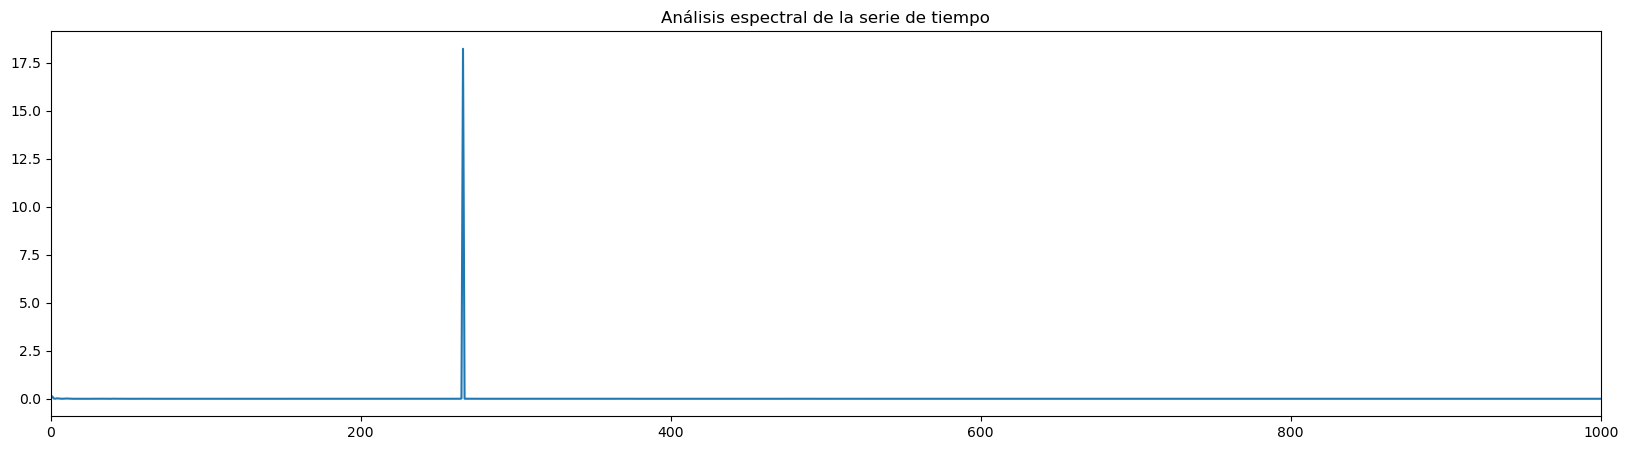

In [16]:
# Vamos a realizar un análisis espectral de la serie original para evaluar sus componentes periódicas
from scipy import signal
G, Pyy_den = signal.periodogram(df['temp'],len(df['temp']))
plt.figure(figsize=(20,5))
plt.plot(G, Pyy_den)
plt.title('Análisis espectral de la serie de tiempo')
plt.xlim(0,1000)
plt.show()


Se puede ver en el análisis espectral una componente significativa alrededor de la frecuencia 365. Esto coincide perfectamente con la periodicidad de la serie a causa de los 365 días del año.

Algunos links utiles:
https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c
https://medium.com/@shawanugya12/implementation-of-time-series-forecasting-methods-sarima-sarimax-and-prophet-ff8407b25aaa
https://www.youtube.com/watch?v=z-uSBE8Pxwg
https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
GRID SEARCH= https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/